# Topic Modeling
\
Topic modeling is a type of statistical modeling used to discover abstract topics within a collection of documents. It helps identify patterns in the text by grouping similar words together, allowing for the extraction of themes or topics that best describe the underlying structure of the data. Common algorithms used for topic modeling include Latent Semantic Analysis (LSA) and Latent Dirichlet Allocation (LDA).\
Before defining the model, though, it is necessary to perform some preliminary operations in order to prepare the corpus for the models:
* **Words listing**
* **Bigrams and Trigrams identification**
* **Removal of most and less frequent terms**
* **Dictionary definition**
* **TF-IDF Matrix, for LSA application**
* **Bag of Words (BoW), for LDA application**

Operations such as stop words removal and tokenization are not necessary, since the text has already been lemmatized in the preprocessing phase.
\
Once these preliminary operations to prepare the corpus are executed, the models were defined: first we let each model train on a range of topics - from a minimum of 7 to a maximum of 15, since the dataset is composed of articles of eterogeneous nature - and for each number we compute the *Cv coherence* and *UMASS coherence* indexes, which, respectively, measure the clear separation and interpretability of topics, and the internal coherence of a single topic.
\
Then, we repeat the procedure select a fitting number of topics by observing the indexes graphs and perform a second training phase, this time with a fixed number of topics. The results are finally displayed using wordclouds and the pyLDAvis library, with a plot showing the most used terms, as well as their effective and estimated frequency, for each topic.

### Packages

In [ ]:
import pandas as pd
import numpy as np
import random
import os
import logging
from pprint import pprint
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Importing gensim packages
import gensim
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phraser
from gensim.models import Phrases
from gensim import corpora
from gensim.corpora import Dictionary
import gensim.models as models
from gensim.models.ldamulticore import LdaMulticore, LdaModel
from gensim.models import LsiModel
from gensim.models import CoherenceModel

In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.7 MB/s eta 0:00:00


In [ ]:
# Importing pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [ ]:
!pip install scikit-learn wordcloud

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [ ]:
# Mounting gDrive
from google.colab import drive
drive.mount("/content/drive")

# set work directory
os.chdir('/content/drive/MyDrive/TM&S_Baghrous_Iarocci_Ferrari')

Mounted at /content/drive


### Loading data

In [ ]:
# File path
file_path = 'Preprocessing/wikiall_processed.csv'

In [ ]:
# CSV file read
wiki_processed = pd.read_csv(file_path, delimiter=',', encoding='utf-8')

In [ ]:
wiki_processed.head()

headline  \
0  keep related supplies area . make effort clean...   
1  create sketch neopoprealist manner future mura...   
2  get bachelor degree . enroll studio based prog...   
3  start experience interest art . understand dif...   
4  keep reference materials sketches articles pho...   

                                                text  \
0  photographer keep necessary lens cords batteri...   
1  see image drawing develops step step . however...   
2  possible become vfx artist without college deg...   
3  best art investors research pieces art buy som...   
4  start planning project work likely gathering s...   

                                  headline_sentences  \
0  ['keep related supplies area .', 'make effort ...   
1  ['create sketch neopoprealist manner future mu...   
2  ['get bachelor degree .', 'enroll studio based...   
3  ['start experience interest art .', 'understan...   
4  ['keep reference materials sketches articles p...   

                                      text_sentences  \
0  ['photographer keep necessary lens cords batte...   
1  ['see image drawing develops step step .', 'ho...   
2  ['possible become vfx artist without college d...   
3  ['best art investors research pieces art buy s...   
4  ['start planning project work likely gathering...   

                                     stemmed_article  \
0  photograph keep necessari len cord batteri qua...   
1  see imag draw develop step step . howev import...   
2  possibl becom vfx artist without colleg degre ...   
3  best art investor research piec art buy someon...   
4  start plan project work like gather scrap insp...   

                                    stemmed_abstract  \
0  keep relat suppli area . make effort clean ded...   
1  creat sketch neopoprealist manner futur mural ...   
2  get bachelor degre . enrol studio base program...   
3  start experi interest art . understand differ ...   
4  keep refer materi sketch articl photo etc one ...   

                                  lemmatized_article  \
0  photographer keep necessary lens cord battery ...   
1  see image drawing develops step step however i...   
2  possible become vfx artist without college deg...   
3  best art investor research piece art buy someo...   
4  start planning project work likely gathering s...   

                                 lemmatized_abstract  
0  keep related supply area make effort clean ded...  
1  create sketch neopoprealist manner future mura...  
2  get bachelor degree enroll studio based progra...  
3  start experience interest art understand diffe...  
4  keep reference material sketch article photo e...

In [ ]:
wiki_processed.lemmatized_article

0         photographer keep necessary lens cord battery ...
1         see image drawing develops step step however i...
2         possible become vfx artist without college deg...
3         best art investor research piece art buy someo...
4         start planning project work likely gathering s...
                                ...                        
214453    name like might fiddle spelling see alternate ...
214454    name might sound great say loud bedroom find s...
214455    relief printing oldest traditional printing te...
214456    intaglio italian incis ing correspondingly rev...
214457    lithography big term often used refer many dif...
Name: lemmatized_article, Length: 214458, dtype: object

In the next chunks of code, we proceed to create a word list, since the text is already lemmatized, for each article, find bigrams and trigrams to obtain a better categorization of topics, remove the most and less used words, define a dictionary, and finally set up Bag of Words to submit to the model.

### Words listing


In [ ]:
# Creating a list of words from the lemmatized article column
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

data = wiki_processed.lemmatized_article.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['photographer', 'keep', 'necessary', 'lens', 'cord', 'battery', 'quadrant', 'home', 'studio', 'paint', 'kept', 'brush', 'cleaner', 'canvas', 'print', 'supply', 'ink', 'etc', 'make', 'broader', 'group', 'area', 'supply', 'make', 'finding', 'easier', 'limiting', 'search', 'much', 'smaller']


### Bigrams and Trigrams

In [ ]:
# Finding bigrams
bigram = Phrases(data_words, min_count=300, threshold=0.3, scoring='npmi')
bigram_mod = Phraser(bigram)

# Finding trigrams
trigram = Phrases(bigram[data_words], min_count=80,  threshold=0.3, scoring='npmi')
trigram_mod = Phraser(trigram)

# Apply bigram and trigram models to the texts
data_words = [bigram_mod[doc] for doc in data_words]
data_words = [trigram_mod[bigram_mod[doc]] for doc in data_words]

In [ ]:
# Set to store unique bigram words
unique_bi = set()

# Iterate over all documents
for idx in range(len(data_words)):
    # Add bigrams to set and print words containing underscores
    words_with_underscore = [token for token in data_words[idx] if '_' in token]
    unique_bi.update(words_with_underscore)

# Set to store unique trigram words with two underscores
unique_tri = set()

# Iterate over all documents
for idx in range(len(data_words)):
    # Add trigrams to set and print words containing two underscores
    words_with_two_underscores = [token for token in data_words[idx] if token.count('_') == 2]
    unique_tri.update(words_with_two_underscores)

In [ ]:
print(len(unique_bi))
print(len(unique_tri))

12434
514


In [ ]:
random_bigrams = random.sample(unique_bi, 20)

for bigram in random_bigrams:
    print(bigram)

darker_shade
tuck_end
delete_data
email_provider
statement_necklace
final_answer
consider_choosing
ginger_garlic
page_layout
spread_germ
fast_growing
stomach_ulcer
growth_spurt
complete_stranger
feel_angry
deep_breathing_exercise
adhesive_remover
current_asset
loose_clothing
repayment_plan


<ipython-input-16-bf2fd3431b13>:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_bigrams = random.sample(unique_bi, 20)


In [ ]:
random_trigrams = random.sample(unique_tri, 10)

for trigram in random_trigrams:
    print(trigram)

customer_service_representative
edit_fill_insert
say_something_like
whole_wheat_flour
aloe_vera_plant
birth_control_pill
boost_self_esteem
hit_enter_keyboard
displaystyle_int_infty
cut_inch_cm


<ipython-input-17-d5e3ca9d6b24>:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_trigrams = random.sample(unique_tri, 10)


## Removing less and most frequent words

In [ ]:
# Computing words frequency in terms of documents
word_doc_freq = defaultdict(int)

# Computing number of documents in which every word appears
for doc in data_words:
    unique_words = set(doc)
    for word in unique_words:
        word_doc_freq[word] += 1

# Setting thresholds for less and most frequents words (bottom 0.05% an top 20%)
num_docs = len(data_words)
min_threshold = 0.0005 * num_docs
max_threshold = 0.2 * num_docs

# Identifying words to remove
words_to_remove = {word for word, freq in word_doc_freq.items() if freq < min_threshold or freq > max_threshold}

# Corpus lenght before removal
print("Lunghezza del corpus prima della rimozione:", sum(len(doc) for doc in data_words))

# Removing most and less frequent words from the text
corpus_cleaned = [[word for word in doc if word not in words_to_remove] for doc in data_words]

# Corpus lenght after removal
print("Lunghezza del corpus dopo la rimozione:", sum(len(doc) for doc in corpus_cleaned))

Lunghezza del corpus prima della rimozione: 43918834
Lunghezza del corpus dopo la rimozione: 36372311


In [ ]:
# Most and less frequent words
less_frequent_words = [word for word, freq in word_doc_freq.items() if freq < min_threshold]
most_frequent_words = [word for word, freq in word_doc_freq.items() if freq > max_threshold]

# Showing a random sample of removed words
sample_less_frequent = random.sample(less_frequent_words, min(20, len(less_frequent_words)))
sample_most_frequent = random.sample(most_frequent_words, min(20, len(most_frequent_words)))

print("\nCampione di parole meno frequenti rimosse:", sample_less_frequent)
print("Campione di parole più frequenti rimosse:", sample_most_frequent)


Campione di parole meno frequenti rimosse: ['wilhelmina', 'golduck', 'upsidedowntext', 'queensrcÿhe', 'monmouthpedia', 'vrat', 'grammy', 'maakt', 'detracted', 'legitimizing', 'outclasses', 'ayia', 'subscription_service', 'mealsas', 'couchsurfing', 'colma', 'hippo', 'walleye', 'glazier', 'mystic']
Campione di parole più frequenti rimosse: ['even', 'two', 'like', 'make', 'people', 'help', 'might', 'place', 'well', 'go', 'many', 'time', 'know', 'find', 'keep', 'look', 'get', 'using', 'put', 'need']


## Dictionary definition

In [ ]:
# Create Dictionary
D = corpora.Dictionary(corpus_cleaned)

# Filtering the dictionary (cut below 0.1% and above 5%)
D.filter_extremes(no_below=0.001, no_above=0.05)
D.filter_tokens(bad_ids=[tokenid for tokenid, word in D.items() if len(word) <= 3])

print("Number of final unique words in the dictionary:", len(D.token2id))

Number of final unique words in the dictionary: 19413


In [ ]:
# Saving the dictionary
D.save('Topic Modeling/LDA model/dictionary12_.dict')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
all_words = [word for doc in corpus_cleaned for word in doc]

In [ ]:
sample_size = 100

random_sample = random.sample(all_words, sample_size)

print("Random Sample of Words:", random_sample)

Random Sample of Words: ['contact_information', 'carrier', 'screen', 'oil', 'book', 'leather', 'price', 'arm', 'food', 'staple', 'claim', 'baby', 'would_like', 'keep_mind', 'boy', 'weight', 'plan', 'towards', 'game', 'placement', 'grew', 'acceptable', 'onion', 'access', 'wanted', 'address', 'rather', 'ready', 'existence', 'development', 'depression', 'spray', 'including', 'aware', 'tightly', 'used', 'suit', 'research_suggests', 'acetate', 'gallon_liter', 'separate', 'feed', 'axe', 'provide', 'networking', 'moving', 'working', 'tape_measure', 'exercising', 'water', 'bag', 'ear', 'change', 'finely', 'illegal', 'fresh_fruit_vegetable', 'policy', 'property_tax', 'move_around', 'test', 'company', 'anything', 'pin', 'bulb', 'different', 'blazer', 'college', 'described', 'hair', 'battery', 'landing', 'exercising', 'breast_milk', 'think', 'fabric_softener', 'box', 'bland', 'determine', 'selfie', 'knot', 'load', 'highest', 'three_four', 'fashion', 'recurring', 'soul', 'best', 'equipment', 'repo

## LSA

In [ ]:
# Create TF-IDF model
tfidf = models.TfidfModel([D.doc2bow(doc) for doc in corpus_cleaned])

# Create TF-IDF corpus
corpus_tfidf = tfidf[[D.doc2bow(doc) for doc in corpus_cleaned]]

# Topics range
num_topics_range = range(7, 16)

# Coherence metrics
cv_scores = []
umass_scores = []

for num_topics in num_topics_range:
    # LSA model
    lsa_model = models.LsiModel(corpus_tfidf, id2word=D, num_topics=num_topics, random_seed=42)

    # Cv coherence
    coherence_model_cv = CoherenceModel(model=lsa_model, texts=corpus_cleaned, dictionary=D, coherence='c_v')
    cv_score = coherence_model_cv.get_coherence()
    cv_scores.append(cv_score)

    # UMass coherence
    coherence_model_umass = CoherenceModel(model=lsa_model, corpus=corpus_tfidf, dictionary=D, coherence='u_mass')
    umass_score = coherence_model_umass.get_coherence()
    umass_scores.append(umass_score)

    print(f'Number of topics: {num_topics} - Coherence Cv: {cv_score} - Coherence UMass: {umass_score}')

Number of topics: 7 - Coherence Cv: 0.49276869986766486 - Coherence UMass: -3.299272232369708
Number of topics: 8 - Coherence Cv: 0.5183378939649594 - Coherence UMass: -2.900978639153981
Number of topics: 9 - Coherence Cv: 0.5169667846721142 - Coherence UMass: -3.092861247121841
Number of topics: 10 - Coherence Cv: 0.4595833981315394 - Coherence UMass: -3.4874090403609883
Number of topics: 11 - Coherence Cv: 0.47296982041998414 - Coherence UMass: -3.4355327174062285
Number of topics: 12 - Coherence Cv: 0.39734639725886617 - Coherence UMass: -3.6076608359734847
Number of topics: 13 - Coherence Cv: 0.426144522509715 - Coherence UMass: -3.5721890031060606
Number of topics: 14 - Coherence Cv: 0.4138818930209906 - Coherence UMass: -3.569745902969768
Number of topics: 15 - Coherence Cv: 0.39681033643267277 - Coherence UMass: -3.5702427603375004
   num_topics  cv_score  umass_score
0           7  0.492769    -3.299272
1           8  0.518338    -2.900979
2           9  0.516967    -3.092861
3

In [ ]:
# Saving the model
lsa_model.save(os.path.join("Topic Modeling/LSA model", "LSAmodel"))

### Cv_coherence and UMASS coherence graphs

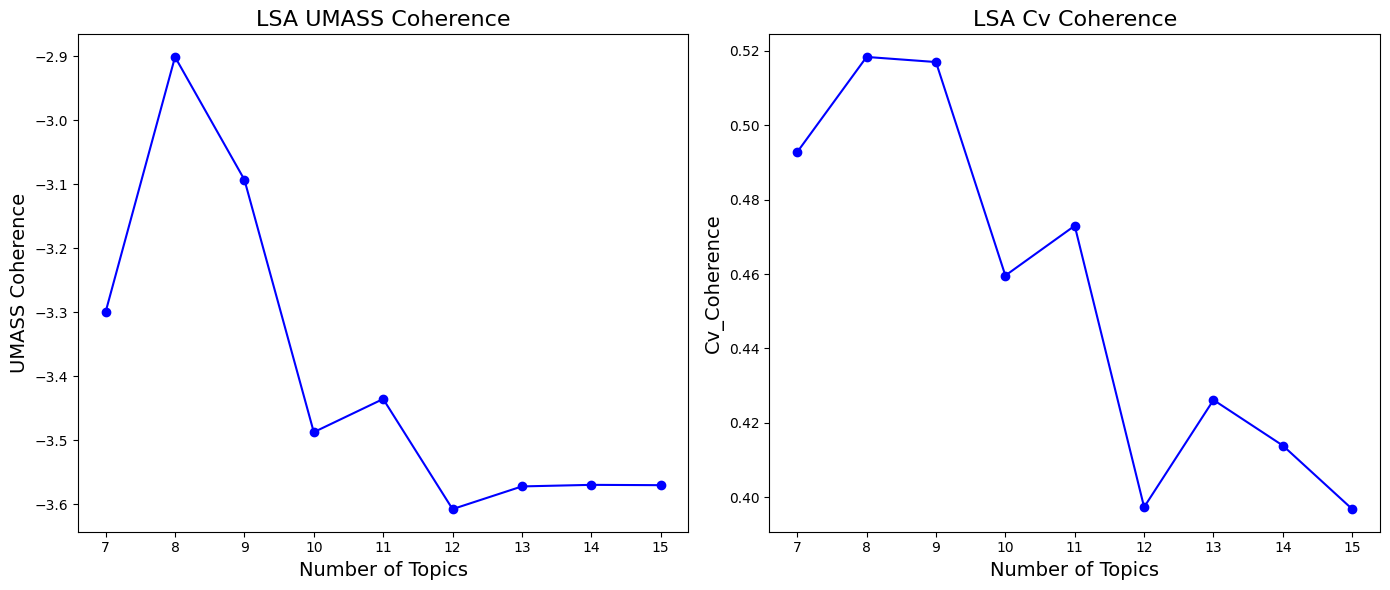

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# UMASS Coherence graph
ax1.plot(num_topics_range, umass_scores, marker='o', linestyle='-', color='b')
ax1.set_xlabel("Number of Topics", fontsize=14)
ax1.set_ylabel("UMASS Coherence", fontsize=14)
ax1.set_title("LSA UMASS Coherence", fontsize=16)

# Cv_Coherence graph
ax2.plot(num_topics_range, cv_scores, marker='o', linestyle='-', color='b')
ax2.set_xlabel("Number of Topics", fontsize=14)
ax2.set_ylabel("Cv_Coherence", fontsize=14)
ax2.set_title("LSA Cv Coherence", fontsize=16)

plt.tight_layout()
plt.show()

### Definitive LSA

In [ ]:
# Setting the number of topics to 8

num_topics = 8

lsa_model = models.LsiModel(corpus_tfidf, id2word=D, num_topics=num_topics, random_seed=42)

# Print Coherence Scores
print("Cv_Coherence:", CoherenceModel(model=lsa_model, texts=corpus_cleaned, dictionary=D, coherence='c_v').get_coherence())
print("UMASS coherence:", CoherenceModel(model=lsa_model, texts=corpus_cleaned, dictionary=D, coherence='u_mass').get_coherence())

Cv_Coherence: 0.5183378939649594
UMASS coherence: -2.900978639153981


### Topic words

In [ ]:
# Print first 10 words for each topic
for idx, topic in lsa_model.print_topics(num_topics=num_topics, num_words=10):
    print(f"Topic {idx+1}:")
    print(topic)
    print("\n")

Topic 1:
0.109*"parent" + 0.092*"partner" + 0.085*"conversation" + 0.082*"class" + 0.080*"business" + 0.077*"girl" + 0.069*"card" + 0.067*"baby" + 0.066*"paint" + 0.065*"teacher"


Topic 2:
0.179*"plant" + 0.152*"mixture" + -0.137*"parent" + 0.124*"dough" + 0.115*"paint" + 0.114*"cake" + 0.106*"stir" + 0.103*"bowl" + 0.099*"stain" + 0.099*"soil"


Topic 3:
-0.259*"parent" + 0.196*"icon" + 0.174*"iphone" + -0.151*"baby" + 0.145*"device" + 0.142*"folder" + 0.142*"photo" + 0.140*"account" + 0.131*"menu" + -0.123*"partner"


Topic 4:
-0.679*"plant" + -0.408*"soil" + -0.158*"garden" + -0.153*"seed" + -0.138*"root" + -0.107*"leaf" + -0.103*"grow" + -0.098*"planting" + -0.097*"flower" + -0.093*"fertilizer"


Topic 5:
0.726*"horse" + 0.171*"baby" + -0.151*"cake" + 0.121*"puppy" + -0.118*"dough" + -0.110*"parent" + 0.086*"stain" + -0.084*"mixture" + -0.081*"plant" + -0.080*"stir"


Topic 6:
-0.654*"horse" + 0.306*"baby" + -0.160*"cake" + -0.134*"dough" + 0.129*"stain" + 0.105*"puppy" + 0.102*"f

### Word Clouds

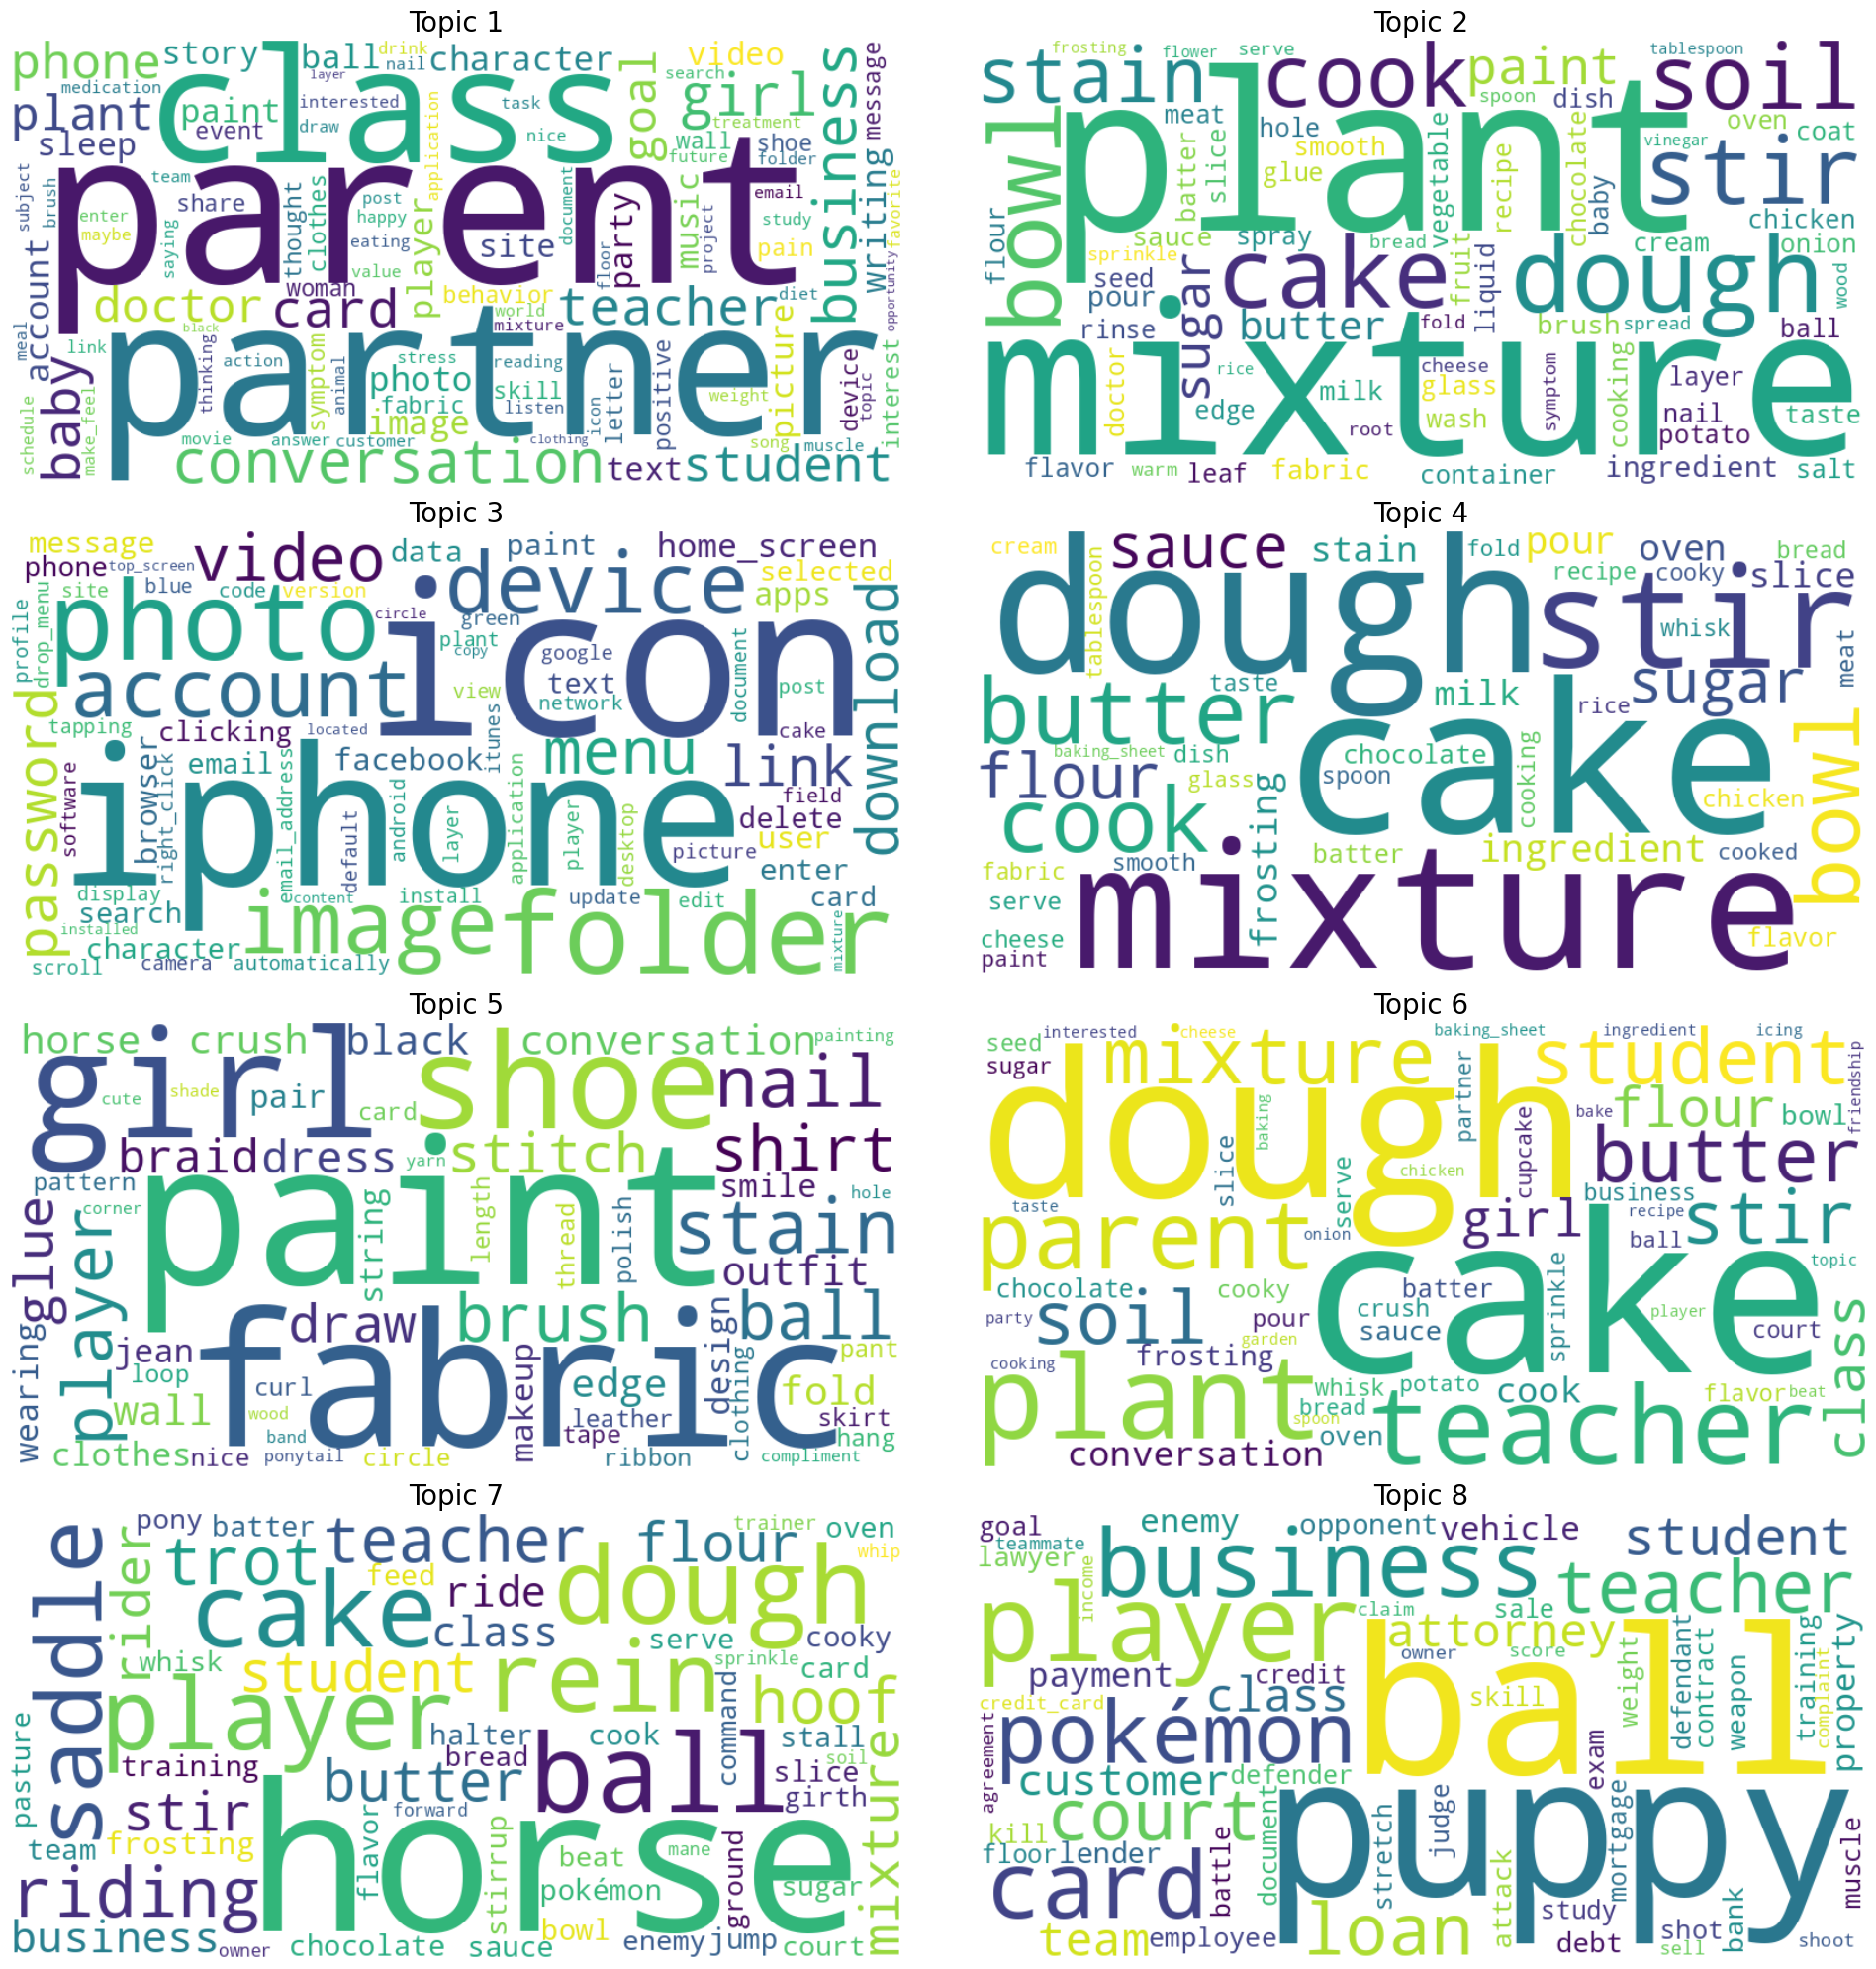

In [ ]:
# Wordcloud function for each topic
def generate_wordcloud(ax, topic_num, topic_words):
    wordcloud = WordCloud(background_color='white', width=800, height=400)
    wordcloud.generate_from_frequencies(dict(topic_words))

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Topic {topic_num + 1}", fontsize=20)

# Words extraction and their probabilities for each topic
topics = lsa_model.show_topics(num_topics=num_topics, num_words=100, formatted=False)
num_topics = len(topics)

num_rows = 4
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

for idx, (topic_num, topic_words) in enumerate(topics):
    row = idx // num_cols
    col = idx % num_cols
    generate_wordcloud(axes[row, col], topic_num, topic_words)

plt.tight_layout()
plt.show()

### BoW text representation for LDA

In [ ]:
# Term Document Frequency
bow_corpus = [D.doc2bow(doc) for doc in corpus_cleaned]

# View
print(bow_corpus[:1][0][:30])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [ ]:
# Saving the bow corpus
import pickle

save_path = 'Topic Modeling/LDA model/bow_corpus.pkl'

# Salvataggio del bow_corpus
with open(save_path, 'wb') as f:
    pickle.dump(bow_corpus, f)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##LDA

In [ ]:
# LDA implementation
ntopics = list(range(7, 16))

# Creating a dataframe to store metrics results
metrics = pd.DataFrame({'topics': ntopics, 'Cv_Coherence': [0.0] * len(ntopics), 'UMASS coherence': [0.0] * len(ntopics)})

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

for num_topics in range(len(ntopics)):
    lda_model = LdaModel(
        random_state=42,
        alpha='symmetric',
        eta="symmetric",
        corpus=bow_corpus,
        chunksize=800,
        passes=10,
        id2word=D,
        num_topics=ntopics[num_topics]
    )

    print("Number of topics:", ntopics[num_topics])

    # Computing coherence scores (for each model)
    cv_coherence = CoherenceModel(model=lda_model, texts=corpus_cleaned, dictionary=D, coherence='c_v').get_coherence()
    umass_coherence = CoherenceModel(model=lda_model, texts=corpus_cleaned, dictionary=D, coherence='u_mass').get_coherence()

    # Updating metrics dataframe
    metrics.at[num_topics, 'Cv_Coherence'] = cv_coherence
    metrics.at[num_topics, 'UMASS coherence'] = umass_coherence

    # Printing metrics
    print("Cv_Coherence:", cv_coherence)
    print("UMASS coherence:", umass_coherence)


print(metrics)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of topics: 7
Cv_Coherence: 0.591148108988772
UMASS coherence: -2.7126694480812152
Number of topics: 8
Cv_Coherence: 0.6010226773060123
UMASS coherence: -2.702057639849061
Number of topics: 9
Cv_Coherence: 0.5744648421314854
UMASS coherence: -2.8723880940414666
Number of topics: 10
Cv_Coherence: 0.5549465554553004
UMASS coherence: -3.0444466354145328
Number of topics: 11
Cv_Coherence: 0.5635300586394388
UMASS coherence: -2.8804906365622873
Number of topics: 12
Cv_Coherence: 0.5263652469185351
UMASS coherence: -3.0556812845724903
Number of topics: 13
Cv_Coherence: 0.5752211982749083
UMASS coherence: -2.9045439108305833
Number of topics: 14
Cv_Coherence: 0.5515494483594243
UMASS coherence: -2.9224020781395046
Number of topics: 15
Cv_Coherence: 0.5650483012581294
UMASS coherence: -2.935167425100632
   topics  Cv_Coherence  UMASS coherence
0       7      0.591148        -2.712669
1       8      0.601023        -2.702058
2       9      0.574465        -2.872388
3      10      0.554947

In [ ]:
# Saving the model
lda_model.save("Topic Modeling/LDA model/modello_lda12_save.lda")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Cv_coherence and UMASS coherence graphs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


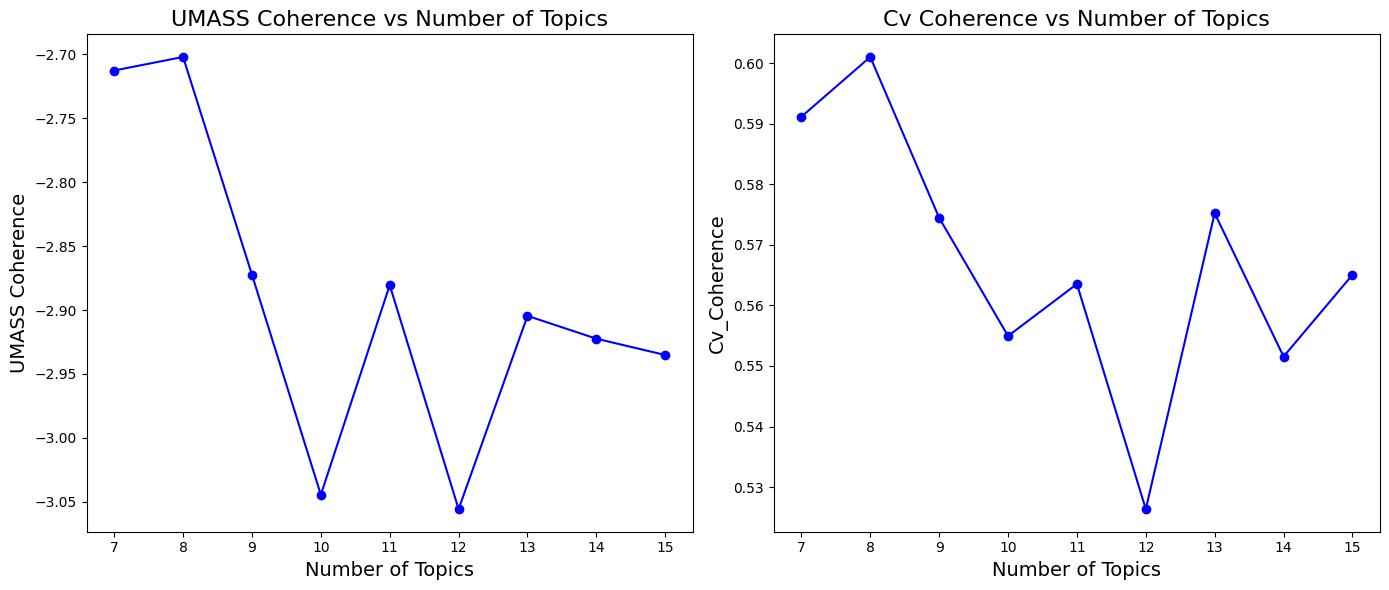

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Grafico per UMASS Coherence
ax1.plot(metrics["topics"].values, metrics["UMASS coherence"].values, marker='o', linestyle='-', color='b')
ax1.set_xlabel("Number of Topics", fontsize=14)
ax1.set_ylabel("UMASS Coherence", fontsize=14)
ax1.set_title("UMASS Coherence vs Number of Topics", fontsize=16)

# Grafico per Cv_Coherence
ax2.plot(metrics["topics"].values, metrics["Cv_Coherence"].values, marker='o', linestyle='-', color='b')
ax2.set_xlabel("Number of Topics", fontsize=14)
ax2.set_ylabel("Cv_Coherence", fontsize=14)
ax2.set_title("Cv Coherence vs Number of Topics", fontsize=16)

plt.tight_layout()
plt.show()

The number of topics is set to 8, since it has the best score for Cv_Coherence index and for UMASS coherence index

In [ ]:
# Saving the metrics
metrics.to_csv('Topic Modeling/LDA model/risultati_metriche12.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Definitive LDA

In [ ]:
# Setting the number of topics to 8
num_topics = 8

lda_model = LdaModel(
            random_state=42,
            alpha='symmetric',
            eta='symmetric',
            corpus=bow_corpus,
            chunksize=800,
            passes=10,
            id2word=D,
            num_topics=num_topics)

# Print Coherence Scores
print("Cv_Coherence:", CoherenceModel(model=lda_model, texts=corpus_cleaned, dictionary=D, coherence='c_v').get_coherence())
print("UMASS coherence:", CoherenceModel(model=lda_model, texts=corpus_cleaned, dictionary=D, coherence='u_mass').get_coherence())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cv_Coherence: 0.6010226773060123
UMASS coherence: -2.702057639849061


In [ ]:
# Save the model
lda_model.save("Topic Modeling/LDA model/modello_lda(8_topics).lda")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Print Keywords for each topic
for t in lda_model.print_topics():
   print(t)
doc_lda = lda_model[bow_corpus]

(0, '0.019*"string" + 0.013*"stitch" + 0.008*"loop" + 0.007*"length" + 0.007*"wheel" + 0.006*"chain" + 0.006*"fold" + 0.006*"edge" + 0.005*"needle" + 0.005*"hook"')
(1, '0.034*"plant" + 0.018*"soil" + 0.009*"tree" + 0.009*"garden" + 0.008*"battery" + 0.007*"root" + 0.007*"player" + 0.007*"grow" + 0.006*"ground" + 0.006*"cable"')
(2, '0.009*"seed" + 0.007*"stem" + 0.006*"growth" + 0.006*"fertilizer" + 0.005*"compost" + 0.004*"fruit" + 0.004*"chemical" + 0.004*"solution" + 0.004*"fluid" + 0.004*"smell"')
(3, '0.011*"card" + 0.010*"chord" + 0.010*"image" + 0.009*"video" + 0.009*"artist" + 0.009*"drum" + 0.007*"film" + 0.007*"site" + 0.007*"music" + 0.006*"letter"')
(4, '0.013*"song" + 0.011*"music" + 0.006*"character" + 0.006*"movie" + 0.006*"guitar" + 0.006*"playing" + 0.005*"voice" + 0.005*"story" + 0.004*"audience" + 0.004*"beat"')
(5, '0.013*"paint" + 0.012*"fabric" + 0.012*"design" + 0.012*"flower" + 0.011*"engine" + 0.010*"yarn" + 0.009*"black" + 0.008*"shirt" + 0.007*"band" + 0.006

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Final Plot using pyLDAvis

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_lda  = gensimvis.prepare(topic_model=lda_model, corpus=bow_corpus, dictionary=D, sort_topics=False)
LDAvis_lda

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.159565  0.113800       1        1   8.973544
1      0.004821 -0.128090       2        1   8.001820
2      0.110888 -0.280589       3        1  16.752750
3     -0.202368  0.166612       4        1   8.783457
4     -0.183342  0.001926       5        1  25.074435
5      0.026809  0.184828       6        1   8.090696
6     -0.212871 -0.117850       7        1  15.237153
7      0.296498  0.059363       8        1   9.086146, topic_info=          Term          Freq         Total Category  logprob  loglift
2808     plant  71857.000000  71857.000000  Default  30.0000  30.0000
1076   vehicle  64271.000000  64271.000000  Default  29.0000  29.0000
849       song  87751.000000  87751.000000  Default  28.0000  28.0000
100     string  42299.000000  42299.000000  Default  27.0000  27.0000
2325      soil  32036.000000  32036.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
3021      inch   8848.310191  16931.799074   Topic8  -5.4525   1.7495
18    cleaning   7661.051857  12821.693491   Topic8  -5.5966   1.8834
77     project   8011.445508  19793.721224   Topic8  -5.5519   1.4939
2911     spray   7535.576573  17549.125604   Topic8  -5.6131   1.5531
568     finish   7058.330818  13562.504009   Topic8  -5.6785   1.7453

[538 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
3475       6  0.999764  accessory
2333       4  0.529248    account
2333       7  0.470702    account
11295      3  0.999907       acid
722        1  0.001331     acting
...      ...       ...        ...
13434      1  0.999687     wrench
2933       1  0.999766      wrist
2478       2  0.945676       yard
2478       8  0.054256       yard
7850       6  0.999937       yarn

[1058 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

### Word Clouds

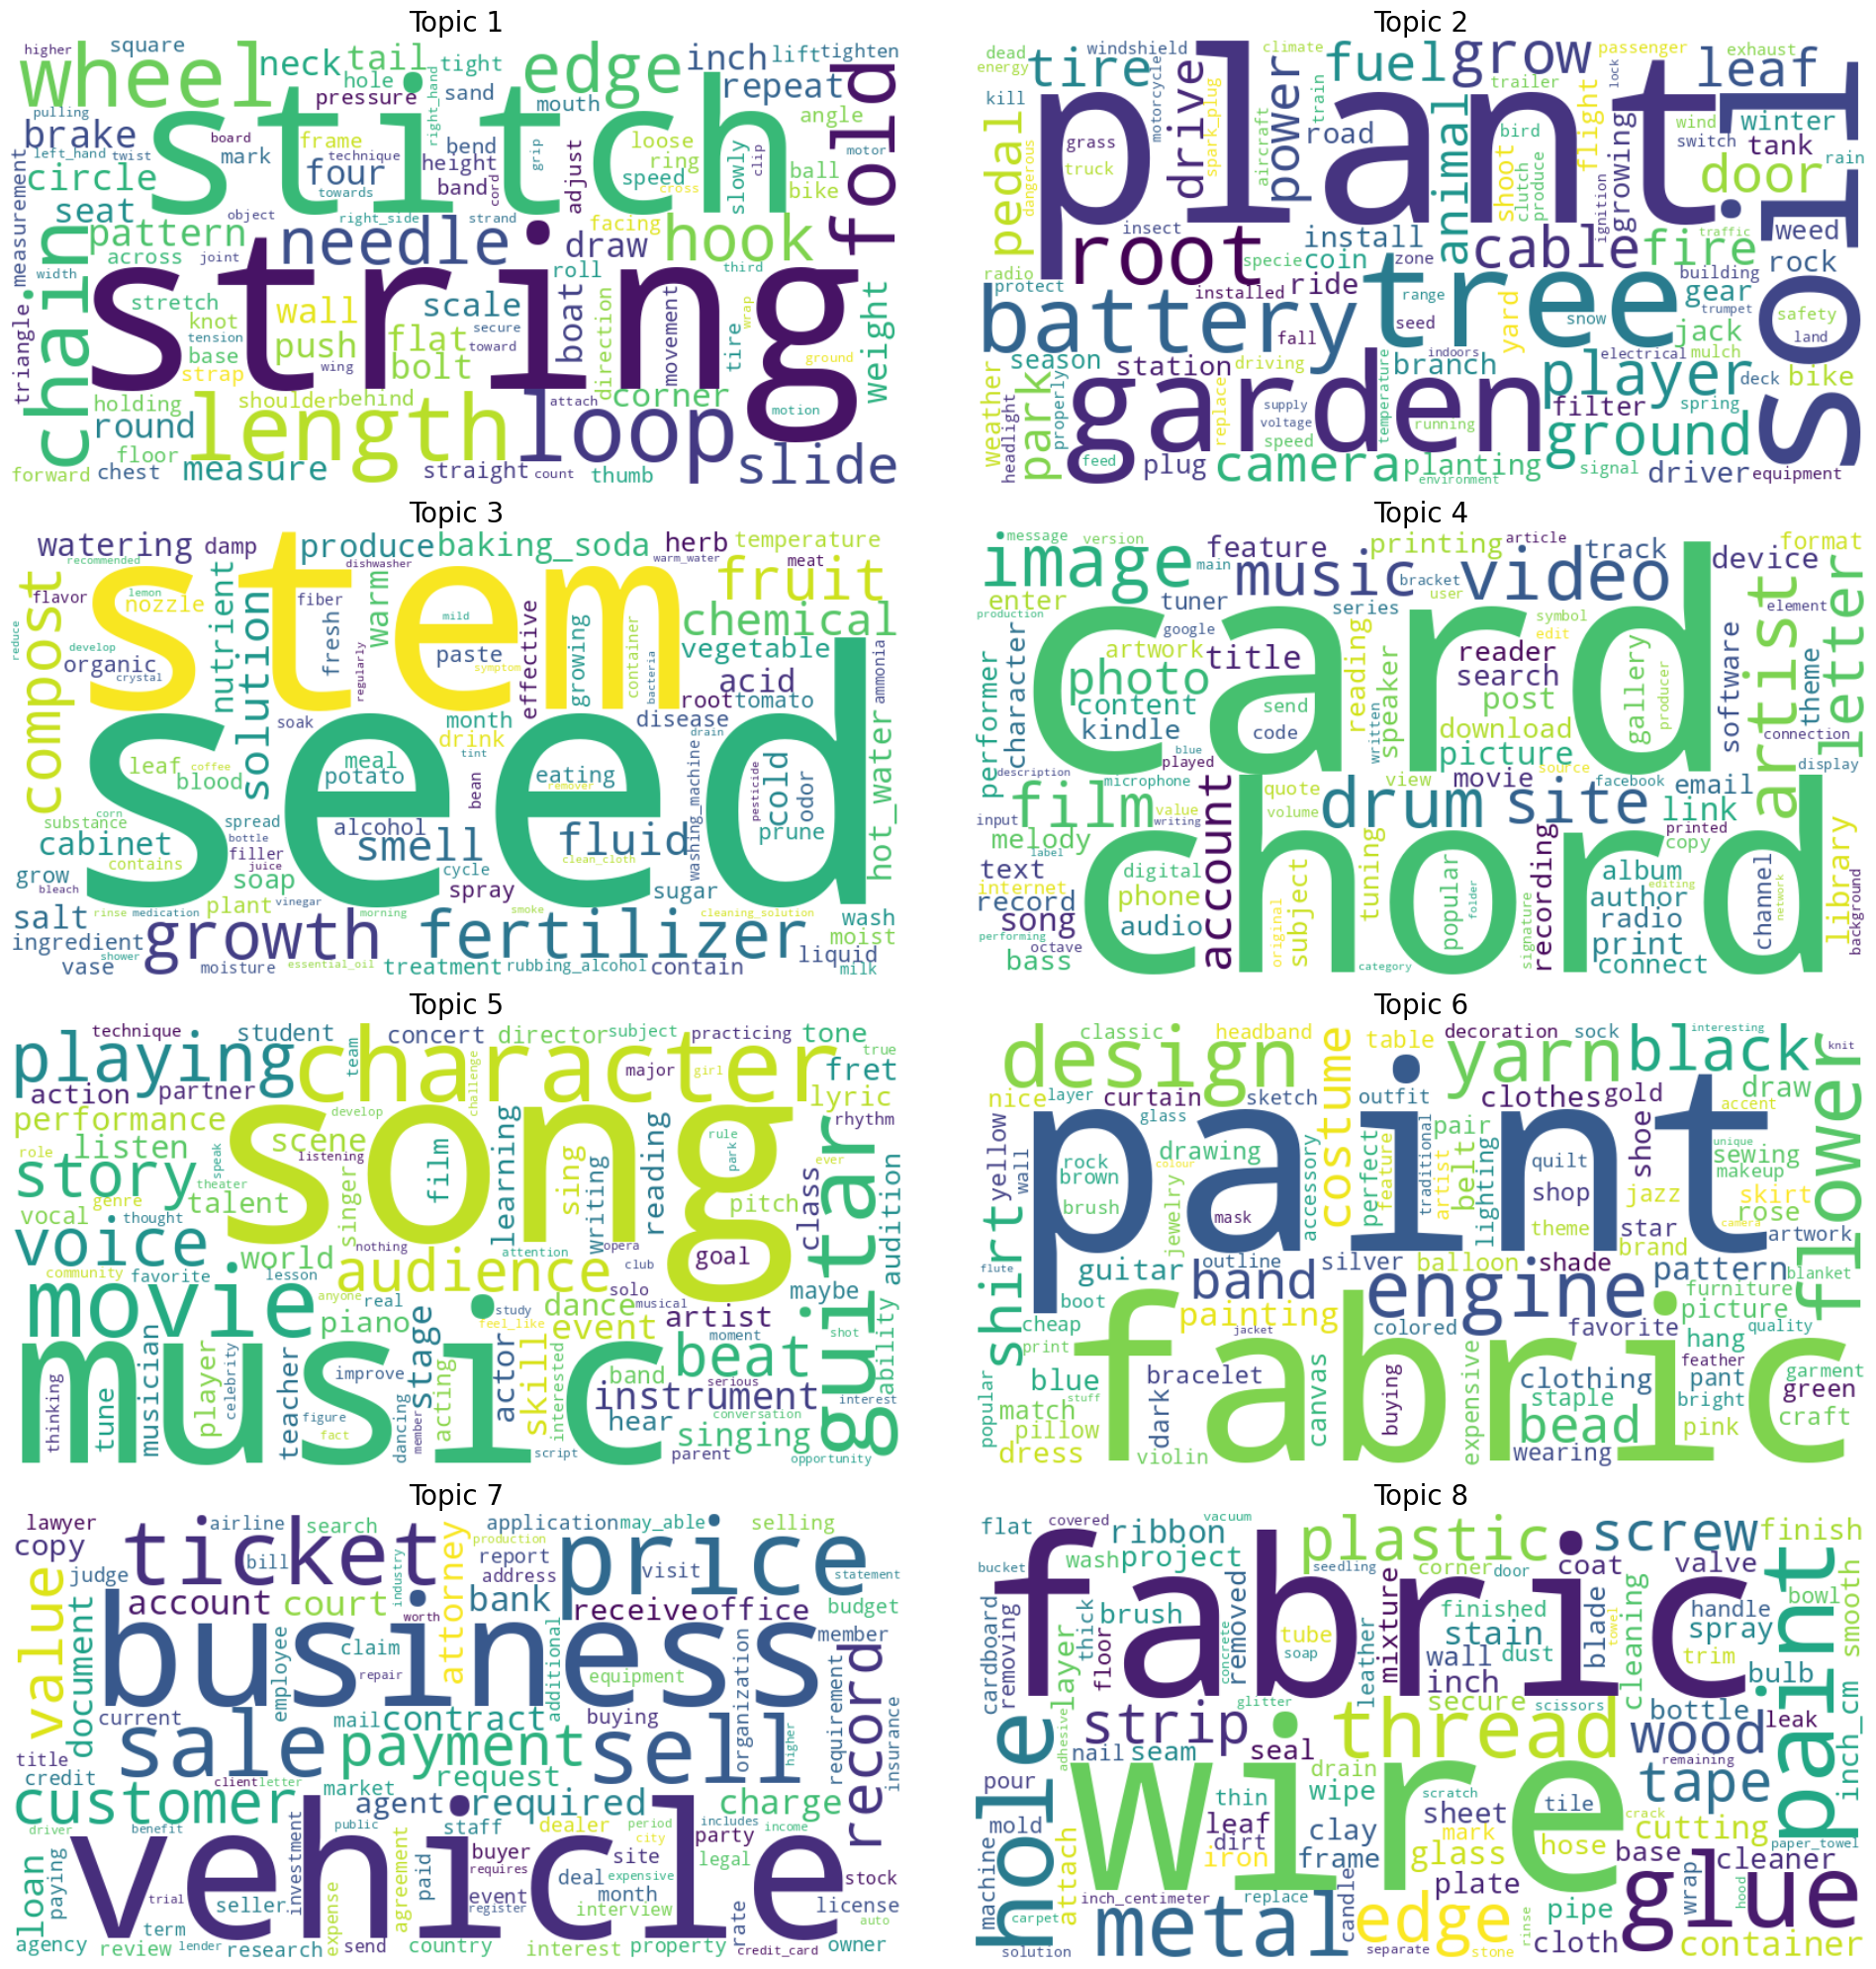

In [ ]:
# Wordcloud function for each topic
def generate_wordcloud(ax, topic_num, topic_words):
    wordcloud = WordCloud(background_color='white', width=800, height=400, contour_width=20)
    wordcloud.generate_from_frequencies(dict(topic_words))

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Topic {topic_num + 1}", fontsize=20)

# Words extraction and their probabilities for each topic
topics = lda_model.show_topics(num_topics=num_topics, num_words=100, formatted=False)
num_topics = len(topics)

num_rows = 4
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

for idx, (topic_num, topic_words) in enumerate(topics):
    row = idx // num_cols
    col = idx % num_cols
    generate_wordcloud(axes[row, col], topic_num, topic_words)

plt.tight_layout()
plt.show()